In [5]:
import os 
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()

base_path = os.getenv("BASE_LOCAL_DIR_PATH")

# Apply Pearson correlation coeifficient to users
---
- 주어진 신청&선정 내역 내, 특정 제품에 대한 동시평가 요소가 너무 적어 새로운 방식 적용 시도.
- 개괄적인 blueprint를 잡기 위한 내용으로, 쉽고 단순한 모델들을 활용해 pre-test 시도.

#### How to get PCC?
- 평점은 user별로 제공받은 제품 빈도 대비 선정율로 정의
- $x$축에는 `user_1` & $y$축에는 `user_2`를 가지는 2차원 평면에서 두 `user`간의 평점 사이에 상관관계를 탐색

In [6]:
df_data_org = pd.read_json(f"{base_path}project_notebook/collaborative_filtering/data/test.json", lines=True)
df_data_org.head()

,id,user_id,item_id,join
0,0,0,0,0
1,1,0,1,0
2,2,0,1,0
3,3,0,0,0
4,4,0,1,0


## Make table of scores 

In [7]:
df_items = df_data_org[['item_id', 'user_id']].groupby('item_id').nunique().reset_index()
list_item = list(df_items.loc[df_items['user_id']>10, ['item_id']]['item_id'])
print(list_item[:10])


[4, 5, 7, 8, 10, 11, 13, 14, 16, 19]


In [8]:
df_data = df_data_org.loc[df_data_org['item_id'].isin(list_item)].copy()

def get_agg(value):
    return pd.Series({"ratio":value['join'].sum() / value['id'].count()}, index=['ratio'])

df_grouped = df_data.groupby(['user_id', 'item_id']).apply(get_agg)
df_grouped.reset_index(inplace=True)
df_grouped.head(10)

,user_id,item_id,ratio
0,0,7,0.200000
1,0,8,0.000000
2,0,10,0.000000
3,0,11,0.750000
4,0,13,0.500000
5,0,16,0.285714
6,0,19,0.000000
7,0,20,0.250000
8,0,30,0.000000
9,0,33,0.000000


## EDA

In [9]:
pcc = df_grouped.copy()
pcc.head()

,user_id,item_id,ratio
0,0,7,0.20
1,0,8,0.00
2,0,10,0.00
3,0,11,0.75
4,0,13,0.50


<AxesSubplot: xlabel='user_id', ylabel='user_id'>

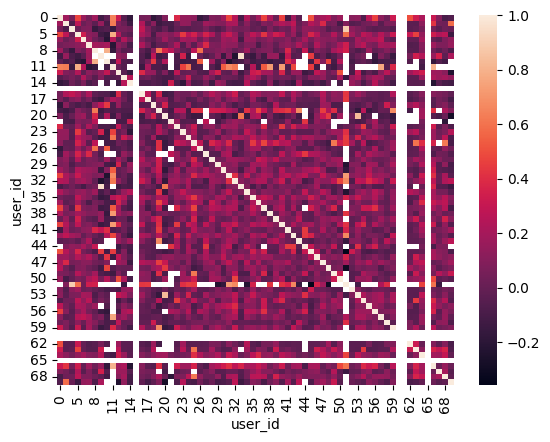

In [10]:
pcc = pcc.pivot(index='item_id', columns='user_id', values='ratio')
pcc_matrix = pcc.corr(method='pearson')
sns.heatmap(pcc_matrix)

In [11]:
pcc_matrix[51].sort_values(ascending=False)[1:10]

user_id
4     0.890076
31    0.726090
32    0.668031
42    0.661438
66    0.600000
5     0.577350
64    0.468047
24    0.452007
17    0.443203
Name: 51, dtype: float64

Text(0.5, 0.98, 'Target is 51')

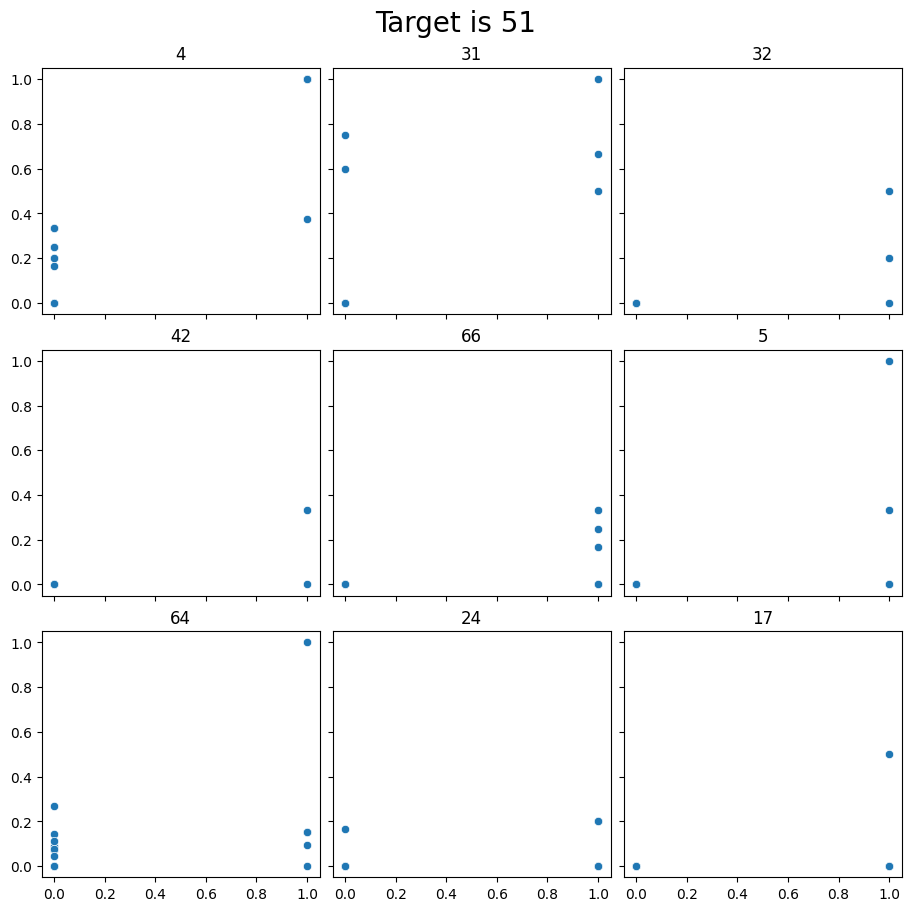

In [30]:
fig, axes = plt.subplots(3,3, figsize=(9,9), sharex=True, sharey=True, constrained_layout=True)
target = 51
for index_, idx in enumerate(pcc_matrix[target].sort_values(ascending=False)[1:10].keys()): 
    sns.scatterplot(
        ax= axes[index_//3, index_%3],
        data=df_grouped.loc[df_grouped['user_id'].isin([target,idx])].pivot(index='item_id', columns='user_id', values='ratio').dropna(),
        x=target,
        y=idx,
    ).set(title=idx, ylabel=None, xlabel=None)

fig.suptitle(f"Target is {target}", fontsize=20)

> pearson correalation이 잘 설명하지 못함을 확인

#### S1. 기준 user 대비, $y=x$에서 벗어난 오차($e$) 총합을 계산 시도.

In [119]:
pcc.head()

user_id,0,3,4,5,6,7,8,9,10,11,...,60,61,62,63,64,65,66,67,68,69
item_id,,,,,,,,,,,,,,,,,,,,,
4,NaN,0.0,0.333333,NaN,0.166667,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,NaN
5,NaN,0.0,0.000000,0.0,0.153846,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
7,0.2,0.4,0.000000,0.0,0.000000,0.25,0.0,NaN,NaN,NaN,...,1.0,NaN,0.0,NaN,0.200000,NaN,NaN,NaN,NaN,NaN
8,0.0,NaN,1.000000,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
10,0.0,0.0,0.000000,0.0,0.000000,0.00,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
def get_error(target_user:int, check_user:int, data:pd.DataFrame=pcc):
    if target_user == check_user:
        return 0
    else:
        data = data.loc[:, [target_user, check_user]].dropna()
        data['error'] = abs(data[target_user] - data[check_user])
        return data['error'].mean()


get_error(0,3)


0.22141053391053392

In [166]:
dict_res = dict()
for idx in list(pcc.columns):
    dict_tmp = dict()
    for idx_2 in list(pcc.columns):
        dict_tmp[idx_2] = get_error(idx, idx_2)
    dict_res[idx] = dict_tmp

df_res = pd.DataFrame(dict_res)

In [163]:
list(df_res[0].sort_values()[1:10].keys())

/var/folders/5v/97lsv0mn5_zf34hm9v9g4_kc0000gn/T/ipykernel_13924/2845805117.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  list(df_res[0].sort_values()[1:10].keys())


[15, 44, 65, 61, 21, 11, 9, 51, 27]

/var/folders/5v/97lsv0mn5_zf34hm9v9g4_kc0000gn/T/ipykernel_13924/747324601.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  list_test = list(df_res[target].sort_values()[1:10].keys())


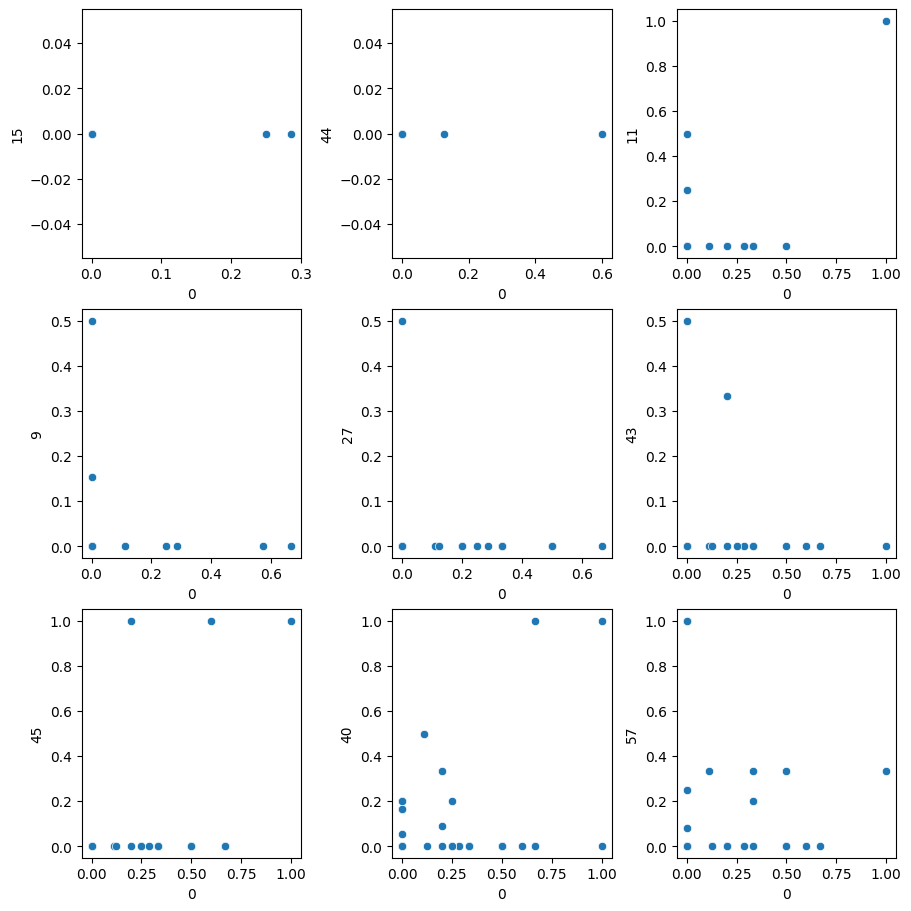

In [167]:
fig, axes = plt.subplots(3,3, figsize=(9,9), constrained_layout=True)
target = 0

list_test = list(df_res[target].sort_values()[1:10].keys())

for index_, idx in enumerate(list_test):
    sns.scatterplot(
        ax= axes[index_//3, index_%3],
        data=df_grouped.loc[df_grouped['user_id'].isin([target,idx])].pivot(index='item_id', columns='user_id', values='ratio').dropna(),
        x=target,
        y=idx
    )

### S2. 오차 범위내 scatter count

In [168]:
pcc.head()

user_id,0,3,4,5,6,7,8,9,10,11,...,60,61,62,63,64,65,66,67,68,69
item_id,,,,,,,,,,,,,,,,,,,,,
4,NaN,0.0,0.333333,NaN,0.166667,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,NaN
5,NaN,0.0,0.000000,0.0,0.153846,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
7,0.2,0.4,0.000000,0.0,0.000000,0.25,0.0,NaN,NaN,NaN,...,1.0,NaN,0.0,NaN,0.200000,NaN,NaN,NaN,NaN,NaN
8,0.0,NaN,1.000000,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
10,0.0,0.0,0.000000,0.0,0.000000,0.00,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
def get_error(target_user:int, check_user:int, data:pd.DataFrame=pcc):
    if target_user == check_user:
        return 0
    else:
        data = data.loc[:, [target_user, check_user]].dropna()
        data['error'] = abs(data[target_user] - data[check_user])
        return len(data.loc[data['error']<0.1])

get_error(0,3)


19

In [74]:
# 일치율
def apply_weight(target_value, check_value):
    alpha = 0.2
    if target_value == check_value:
        return 1
    elif (check_value > target_value*(1-alpha)) & (check_value < target_value*(1+alpha)):
        return 1
    else:
        return 0

def get_relation_cnt(target_user:int, check_user:int, data:pd.DataFrame=pcc):
    if target_user == check_user:
        return None
    else:
        data = data.loc[:, [target_user, check_user]].dropna()
        data = data.drop(data.loc[(data[target_user]==0)&(data[check_user]==0)].index)
        if len(data) == 0:
            return 0
        data['cnt'] = data.apply(lambda row: apply_weight(row[target_user], row[check_user]), axis=1)
        return data['cnt'].sum() / len(data)

get_relation_cnt(0,3)


0.037037037037037035

In [75]:
dict_res = dict()
for idx in list(pcc.columns):
    dict_tmp = dict()
    for idx_2 in list(pcc.columns):
        dict_tmp[idx_2] = get_relation_cnt(idx, idx_2)
    dict_res[idx] = dict_tmp

df_res = pd.DataFrame(dict_res)
df_res

,0,3,4,5,6,7,8,9,10,11,...,60,61,62,63,64,65,66,67,68,69
0,NaN,0.037037,0.061224,0.125000,0.024390,0.000000,0.066667,0.000000,0.0,0.111111,...,0.000000,0.000000,0.050000,0.055556,0.075000,0.000000,0.000000,0.000000,0.071429,0.055556
3,0.037037,NaN,0.061856,0.054545,0.019231,0.044118,0.000000,0.071429,0.0,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.032520,0.000000,0.000000,0.000000,0.034483,0.055556
4,0.061224,0.072165,NaN,0.031496,0.025974,0.054545,0.010101,0.000000,0.0,0.000000,...,0.000000,0.333333,0.000000,0.023256,0.033088,0.333333,0.012821,0.000000,0.033333,0.000000
5,0.125000,0.054545,0.031496,NaN,0.009804,0.018519,0.029412,0.000000,0.0,0.250000,...,0.000000,0.000000,0.050000,0.062500,0.009009,0.000000,0.000000,0.035714,0.028571,0.000000
6,0.024390,0.019231,0.017316,0.009804,NaN,0.028302,0.000000,0.000000,0.0,0.000000,...,0.000000,0.111111,0.014493,0.018182,0.051205,0.000000,0.027273,0.016000,0.014388,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.250000,0.000000,0.000000,0.000000
66,0.000000,0.000000,0.012821,0.000000,0.027273,0.022222,0.000000,0.107143,0.0,0.142857,...,0.000000,0.000000,0.013333,0.037037,0.043750,0.250000,NaN,0.000000,0.032258,0.000000
67,0.000000,0.000000,0.000000,0.035714,0.016000,0.023256,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.142857,0.013636,0.000000,0.000000,NaN,0.011765,0.000000
68,0.071429,0.034483,0.033333,0.028571,0.014388,0.036364,0.000000,0.071429,0.0,0.000000,...,0.333333,0.000000,0.000000,0.037037,0.034653,0.000000,0.032258,0.023529,NaN,0.058824


<AxesSubplot: >

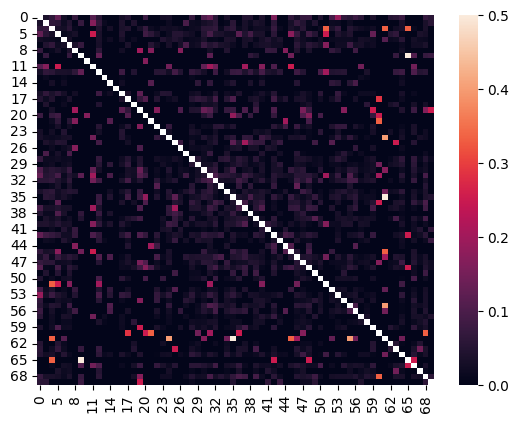

In [76]:
sns.heatmap(df_res)

Text(0.5, 0.98, 'Target is 51')

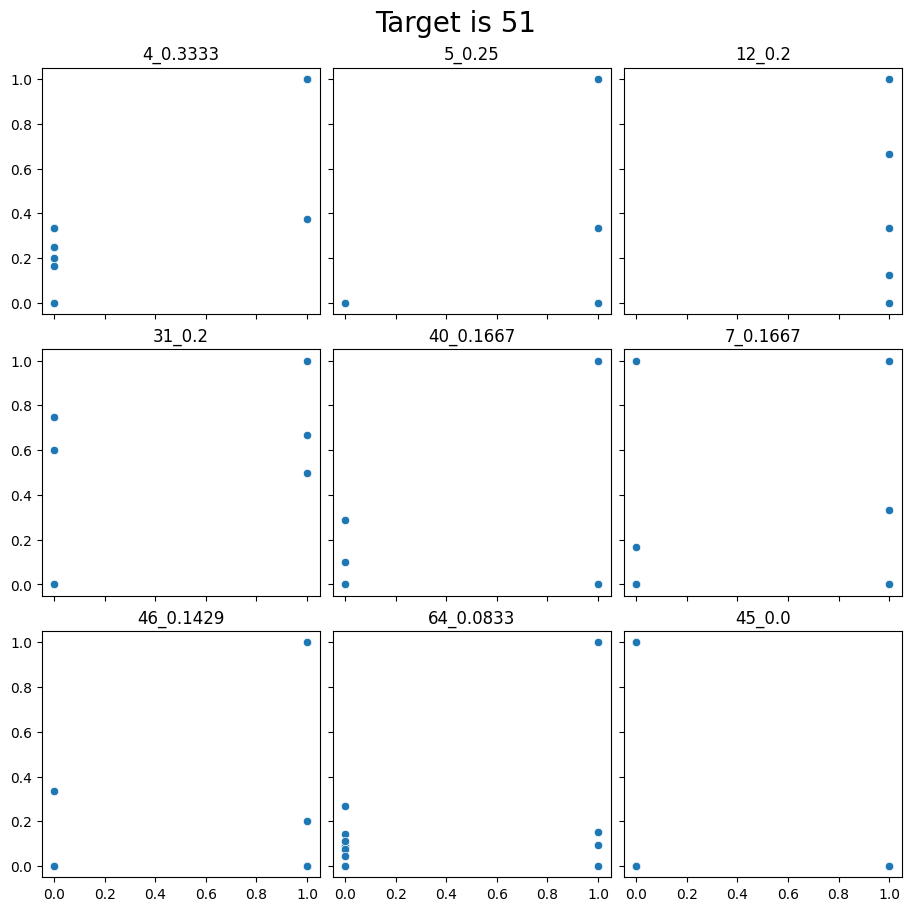

In [97]:
fig, axes = plt.subplots(3,3, figsize=(9,9), sharex=True, sharey=True, constrained_layout=True)

target = 51

for index_, idx in enumerate(df_res[target].sort_values(ascending=False)[:9].items()):
    sns.scatterplot(
        ax= axes[index_//3, index_%3],
        data=df_grouped.loc[df_grouped['user_id'].isin([target,idx[0]])].pivot(index='item_id', columns='user_id', values='ratio').dropna(),
        x=target,
        y=idx[0]
    ).set(title=f"{idx[0]}_{round(idx[1],4)}", ylabel=None, xlabel=None)
fig.suptitle(f"Target is {target}", fontsize=20)



## EDA for samples
- standard of samples : top 10 of user based on join_cnt

In [19]:
top_10 = list(df_data[['user_id', 'join']].groupby('user_id').sum().reset_index().sort_values(by='join', ascending=False)[:10]['user_id'])
top_10


[64, 6, 28, 47, 4, 34, 29, 31, 48, 59]

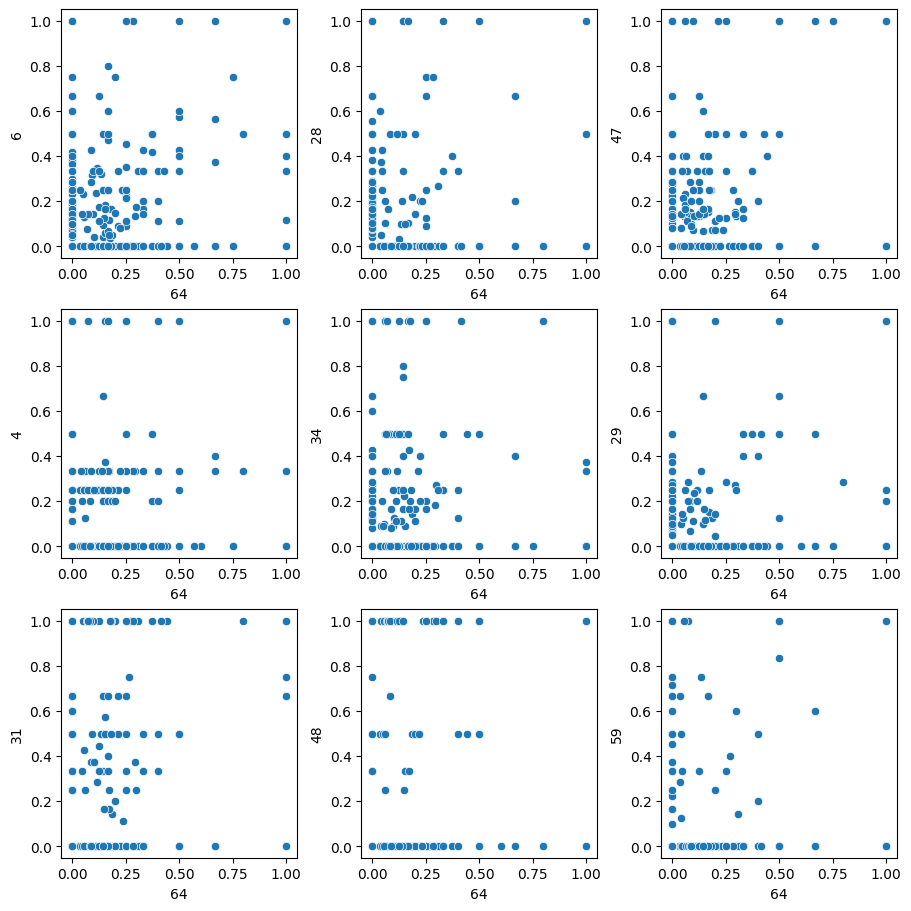

In [42]:
fig, axes = plt.subplots(3,3, figsize=(9,9), constrained_layout=True)

for index_, idx in enumerate(top_10[1:]): 
    sns.scatterplot(
        ax= axes[index_//3, index_%3],
        data=df_grouped.loc[df_grouped['user_id'].isin([64,idx])].pivot(index='item_id', columns='user_id', values='ratio').dropna(),
        x=64,
        y=idx
    )
# sns.scatterplot(
#     data=df_grouped.loc[df_grouped['user_id'].isin([6,64])].pivot(index='item_id', columns='user_id', values='ratio').dropna(),
#     x=6,
#     y=64
# )

IndexError: index 4 is out of bounds for axis 1 with size 2

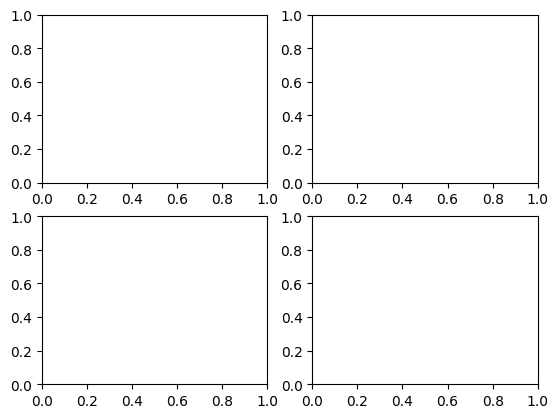

In [39]:
tmp_fig, tmp_axes = plt.subplots(2,2)
sns.lineplot(ax=tmp_axes[0,4], x = [1,2,3,4], y=[1,2,3,4])

In [41]:
for idx in range(9):
    print(idx//3, idx%3)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
